# Flax-Pilot VAE MNIST Notebook

This notebook demonstrates the usage of flax-pilot to train a VAE. The workflow uses distributed training using jax.pmap on Kaggle GPU

**Use TensorFlow-cpu instead of TensorFlow to avoid any issues between TensorFlow & Jax.**

In [1]:
!pip install -q tensorflow-cpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.3.2 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.


In [2]:
import jax
import optax
import tensorflow as tf
import flax.linen as nn
import jax.numpy as jnp
import jax.random as jr

In [3]:
import jax, flax, orbax.checkpoint
jax.__version__, flax.__version__, orbax.checkpoint.__version__

('0.4.26', '0.8.4', '0.5.15')

### Create a simple VAE Model.

*Note: The main model must always have a '**deterministic**' param to handle layers like dropout. Not adding '**deterministic**' param will lead to error as flax-pilot always expects this param, irrespective of whether the model has any stochastic layers or not.*

In [86]:
class Encoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Conv(features=32, kernel_size=(3, 3), strides=2, padding='SAME')(x))
        x = nn.relu(nn.Conv(features=64, kernel_size=(3, 3), strides=2, padding='SAME')(x))
        x = x.reshape(x.shape[0], -1)
        x = nn.relu(nn.Dense(16)(x))
        mean = nn.Dense(2)(x)
        logvar = nn.Dense(2)(x)
        return mean, logvar

    
class Decoder(nn.Module):    
    @nn.compact
    def __call__(self, z):
        y = nn.relu(nn.Dense(49*64)(z))
        y = y.reshape(y.shape[0], 7, 7, 64)
        y = nn.relu(nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y = nn.relu(nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y = nn.ConvTranspose(features=1, kernel_size=(3, 3), padding='SAME')(y)
        y = nn.sigmoid(y)
        return y
        
        
class VAE(nn.Module):
    def setup(self,):
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    
    # Must have 'deterministic param'.
    @nn.compact
    def __call__(self, x, deterministic):
        mean, logvar = self.encode(x)
        z = self.reparam_trick(mean, logvar)
        y = self.decode(z)
        return (mean, logvar), y
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def reparam_trick(self, mean, logvar):
        e = jr.normal(self.make_rng('normal'), mean.shape)
        return mean + jnp.exp(0.5*logvar)*e


### Create tf.data.Dataset
Distributed training in this notebook is performed using jax.pmap. jax.pmap expects the first dimension of its input tensor as the number of devices in parallel.<br>
<br> 
So Input tensor must have shape **(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)**<br>
MNIST Images have shape : **(28, 28, 1)**<br>
In this case, input shape will be : **(2, 128, 28, 28, 1)**. So, we have 2 devices, each device will receive a batch of shape **(128, 28, 28, 1)**.

GLOBAL_BATCH_SIZE = LOCAL_BATCH_SIZE * NO_OF_DEVICES<br>
In this case, GLOBAL_BATCH_SIZE = 256

In [82]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(256).batch(128, True)
train_ds = train_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255), num_parallel_calls=tf.data.AUTOTUNE)

# Second batching for distributing with pmap.
train_ds = train_ds.batch(2, True)
train_ds = train_ds.repeat().as_numpy_iterator()

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.shuffle(256).batch(128, True)
val_ds = val_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(2, True)
val_ds = val_ds.repeat().as_numpy_iterator()

train_ds, val_ds

(NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7d66207eeda0>),
 NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7d66262a8d00>))

### Loss Function

#### Inputs to the loss function

##### The `loss_fn` will always receive these five specific inputs, described as follows:

1. **params**:
   - **Description**: The model's parameters.
   - **Obtained by**: Using the `init` method of `flax.linen.Module`.
   - **Example**: `params = model.init(prng_key, input_shape)`.



2. **apply**:
   - **Description**: The `apply` method from `flax.linen.Module`, used to call other methods within the module.



3. **sample**:
   - **Description**: The input data to the model.


4. **deterministic**:
   - **Description**: Indicates whether to enable deterministic behavior in layers (similar to the `training` parameter in Keras).
   - **Usage**: 
     - Set to `True` during validation (`val_step`), where dropout is disabled.
     - Set to `False` during training (`train_step`).



5. **global_key**:
   - **Description**: A PRNGKey used to seed random variables, important for dropout and other random operations within the model.
   - **Management**: 
     - Updated using `jax.fold_in` within the `train_step` and `val_step` functions to ensure a unique key for each step.
     - When flax model requires multliple keys in its forward pass, the global key received here can be splitted into multliple keys using `jax.random.split`. These splits can be represented as a dict where keys are the `rng_name` used from within the model using `self.make_rng(rng_name)` and value as the key itself.
     - From within the model, keys can be accessed by `self.make_rng(rng_name)`.


### Note:
- All these five parameters are crucial for training and must not be removed or replaced.
- Their names can be changed, but their order and functionality must remain the same.



This structure ensures that the `loss_fn` receives all necessary inputs in a consistent manner, facilitating proper model training and evaluation.

#### Outputs from the loss function

The function must return two elements:

1. **Scalar loss**:
   - **Description**: The value which should be minimized.
   - **Details**: This scalar is minimized with respect to the first parameter of the function, `params`.



2. **loss_metric_values_dict**:
   - **Description**: A dictionary that must always contain two keys, **'mt'** (metric tracker) and **'lt'** (loss tracker).
   - **Structure**:
     - Each of these parent keys must hold a child dictionary as its value, representing different metric and loss trackers.
     - The child dictionary's key names can be any string but must match with the tracker instances dictionary (explained in later cells).
     - The child dictionary's values must be the values being tracked.
   - **Details**:
     - For losses, the loss tracker is used to track the losses, so the child dictionaries of **'lt'** must have scalar loss as their values.
     - For classification metrics like Accuracy or F1Score, the child dictionary of **'mt'** will expect a tuple of `(y_true, y_pred)` as its value or a dictionary like `{'true': true, 'pred': pred}` as its value.
     - These values of child dict are passed to the `update` function of tracker instances. Check out `trackers.py` to understand the expected inputs of each tracker's update function.

In [83]:
def loss_fn(params, apply, sample, deterministic, global_key):
    x = sample
    (mean, logvar), y = apply(params, x, deterministic=deterministic, rngs={'normal': global_key})
    
    recons_loss = -(x*jnp.log(y+0.00001) + (1-x)*jnp.log(1-y+0.00001)).sum(axis=(1, 2)).mean()
    kl_loss = (-0.5 * (1 + logvar - jnp.square(mean) - jnp.exp(logvar))).sum(axis=(1, )).mean()
    loss = recons_loss + kl_loss
    loss_metric_values_dict = { 
        'lt': {'kl_loss': kl_loss.mean(), 'recons_loss': recons_loss.mean()},
        'mt': dict()
        }
    return loss, loss_metric_values_dict


In [72]:
import glob, sys
sys.path.append("/kaggle/input")

### Creating tracker functions

Trackers are represented in a dictionary, with keys **'mt'** (metric tracker) and **'lt'** (loss tracker) being mandatory. Each of these keys must have a child dictionary as its value. The child dictionary's key names must match the child key names in `loss_metric_values_dict`. The value of the child dictionaries must be tracker instances.


In [84]:
import trackers as tr

trackers = {
        'lt': {'kl_loss': tr.Mean(), 'recons_loss': tr.Mean()},
        'mt':{}
}

### Trainer

The `Trainer` instance takes in five parameters:

1. **flax_model**:
   - **Description**: A `flax.linen.Module` instance.



2. **input_shape**:
   - **Description**: Shapes of input tensors passed to the model.
   - **Type**: A dictionary where the key is the parameter name of the model's `__call__` method and the value is the shape of the tensor.



3. **optimizer**:
   - **Description**: An `optax` optimizer.



4. **loss_metric_fn**:
   - **Description**: The loss function as explained above.



5. **trackers**:
   - **Description**: A dictionary of trackers as explained in the previous cell.

In [92]:
from trainer import Trainer
trainer = Trainer(VAE(), {'x': (1, 28, 28, 1)}, optax.adam(0.001), loss_fn, trackers)

Check the docstring of **Trainer.train** for explaination 

In [91]:
trainer.train(20, train_ds, val_ds, 60000//256, 10000//256, '/kaggle/working/mnist-ds/vae_model', 1)

Epoch 1: 100%|██████████| 234/234 [00:01<00:00, 166.84it/s]


Train:  kl_loss: 6.08879, recons_loss: 148.76147, time: 1.4055016040802002
Val:  kl_loss: 6.173652, recons_loss: 150.40417, time: 0.07926774024963379
State saved..


Epoch 2: 100%|██████████| 234/234 [00:01<00:00, 173.20it/s]


Train:  kl_loss: 6.1104393, recons_loss: 148.36182, time: 1.353722333908081
Val:  kl_loss: 6.1402874, recons_loss: 150.14574, time: 0.07532262802124023
State saved..


Epoch 3: 100%|██████████| 234/234 [00:01<00:00, 172.22it/s]


Train:  kl_loss: 6.120078, recons_loss: 148.11195, time: 1.3614792823791504
Val:  kl_loss: 6.2498426, recons_loss: 150.16829, time: 0.0821218490600586
State saved..


Epoch 4: 100%|██████████| 234/234 [00:01<00:00, 172.59it/s]


Train:  kl_loss: 6.1356573, recons_loss: 147.9931, time: 1.3592300415039062
Val:  kl_loss: 6.2226295, recons_loss: 149.7565, time: 0.07018470764160156
State saved..


Epoch 5: 100%|██████████| 234/234 [00:01<00:00, 172.07it/s]


Train:  kl_loss: 6.1439705, recons_loss: 147.73303, time: 1.3626213073730469
Val:  kl_loss: 6.148568, recons_loss: 150.31537, time: 0.07863903045654297
State saved..


Epoch 6: 100%|██████████| 234/234 [00:01<00:00, 171.53it/s]


Train:  kl_loss: 6.1521044, recons_loss: 147.4898, time: 1.3670034408569336
Val:  kl_loss: 6.204656, recons_loss: 149.73273, time: 0.0707862377166748
State saved..


Epoch 7: 100%|██████████| 234/234 [00:01<00:00, 170.82it/s]


Train:  kl_loss: 6.166006, recons_loss: 147.27997, time: 1.3725688457489014
Val:  kl_loss: 6.266787, recons_loss: 149.85431, time: 0.07687592506408691
State saved..


Epoch 8: 100%|██████████| 234/234 [00:01<00:00, 170.15it/s]


Train:  kl_loss: 6.157774, recons_loss: 147.11444, time: 1.3779840469360352
Val:  kl_loss: 6.177784, recons_loss: 149.61649, time: 0.0738980770111084
State saved..


Epoch 9: 100%|██████████| 234/234 [00:01<00:00, 169.58it/s]


Train:  kl_loss: 6.1691837, recons_loss: 146.9252, time: 1.3826899528503418
Val:  kl_loss: 6.2074842, recons_loss: 149.59073, time: 0.08005309104919434
State saved..


Epoch 10: 100%|██████████| 234/234 [00:01<00:00, 168.89it/s]


Train:  kl_loss: 6.172928, recons_loss: 146.73073, time: 1.388460397720337
Val:  kl_loss: 6.196461, recons_loss: 149.48114, time: 0.07204437255859375
State saved..


Epoch 11: 100%|██████████| 234/234 [00:01<00:00, 167.78it/s]


Train:  kl_loss: 6.206852, recons_loss: 146.62834, time: 1.3974723815917969
Val:  kl_loss: 6.1791706, recons_loss: 149.54593, time: 0.07859134674072266
State saved..


Epoch 12: 100%|██████████| 234/234 [00:01<00:00, 168.07it/s]


Train:  kl_loss: 6.2113986, recons_loss: 146.35889, time: 1.395115613937378
Val:  kl_loss: 6.108198, recons_loss: 149.17732, time: 0.08536195755004883
State saved..


Epoch 13: 100%|██████████| 234/234 [00:01<00:00, 166.74it/s]


Train:  kl_loss: 6.2122355, recons_loss: 146.31711, time: 1.406327486038208
Val:  kl_loss: 6.15571, recons_loss: 148.7622, time: 0.07639241218566895
State saved..


Epoch 14: 100%|██████████| 234/234 [00:01<00:00, 166.73it/s]


Train:  kl_loss: 6.235655, recons_loss: 146.12082, time: 1.4063520431518555
Val:  kl_loss: 6.1941886, recons_loss: 148.75262, time: 0.07448530197143555
State saved..


Epoch 15: 100%|██████████| 234/234 [00:01<00:00, 166.84it/s]


Train:  kl_loss: 6.236308, recons_loss: 145.96294, time: 1.4054477214813232
Val:  kl_loss: 6.196903, recons_loss: 148.65822, time: 0.08444809913635254
State saved..


Epoch 16: 100%|██████████| 234/234 [00:01<00:00, 166.58it/s]


Train:  kl_loss: 6.2482576, recons_loss: 145.86543, time: 1.4073896408081055
Val:  kl_loss: 6.0790167, recons_loss: 148.83124, time: 0.07044625282287598
State saved..


Epoch 17: 100%|██████████| 234/234 [00:01<00:00, 167.16it/s]


Train:  kl_loss: 6.2429247, recons_loss: 145.79771, time: 1.4025425910949707
Val:  kl_loss: 6.2578154, recons_loss: 148.78241, time: 0.07971692085266113
State saved..


Epoch 18: 100%|██████████| 234/234 [00:01<00:00, 167.07it/s]


Train:  kl_loss: 6.268744, recons_loss: 145.5662, time: 1.4032933712005615
Val:  kl_loss: 6.1169424, recons_loss: 148.96024, time: 0.06870293617248535
State saved..


Epoch 19: 100%|██████████| 234/234 [00:01<00:00, 167.88it/s]


Train:  kl_loss: 6.2780585, recons_loss: 145.5075, time: 1.3962457180023193
Val:  kl_loss: 6.241952, recons_loss: 149.33752, time: 0.07831907272338867
State saved..


Epoch 20: 100%|██████████| 234/234 [00:01<00:00, 168.64it/s]


Train:  kl_loss: 6.295164, recons_loss: 145.37387, time: 1.3902170658111572
Val:  kl_loss: 6.321716, recons_loss: 148.6029, time: 0.07320523262023926
State saved..


### Access any method of the model

To access methods of the model, one can call the Trainer instance. **Check docstring to understand its working.**
<br>The params are explained below

1. **rngs**:
   - **Description**: A dictionary where the values are `jax.random.PRNGKey` instances and the keys are the names used inside the model to reference these PRNGKeys.



2. **tensor_inputs**:
   - **Description**: The tensor inputs passed to the model's method you plan to call.
   - **Type**: A dictionary where each key is the name of a method parameter and each value is the corresponding tensor input.
   - **Note**: Tensor inputs must include a device dimension due to `jax.pmap` decoration, e.g., `(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)`.



3. **method**:
   - **Description**: A string representing the method of the model you plan to call.
   - **Default**: The default value is the `__call__` method.



4. **kwargs**:
   - **Description**: Used to pass any static arguments to the method, such as the `deterministic` parameter.



Below are some examples.

*Note: Tensor inputs to methods are jax.pmap decorated so, inputs must include device dimension. For ex. __(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)__*

#### Model call
The callable Trainer function accepts param '**method**' which represents the which method of the model to call. Default value is the **call** method.

In [52]:
sample = next(val_ds)[:, :8]

rngs = {'normal': jax.random.PRNGKey(53)}
tensor_inputs = {'x': sample}

output = trainer(rngs, tensor_inputs, deterministic=False)[1]

#### Model.decode

In [94]:
rand = jr.normal(jr.PRNGKey(53), (2, 8, 2))

rngs = {'normal': jax.random.PRNGKey(13)}
tensor_inputs = {'x': rand}

output = trainer(rngs, tensor_inputs, method='decode')

### Evaluate the model

In [54]:
trainer.evaluate(val_ds, 10000//256)

Val:  kl_loss: 5.970701, recons_loss: 152.13593, time: 0.07072973251342773


### Compute trackers

In [55]:
trainer.compute_trackers()

{'lt': {'kl_loss': Array([5.967291, 5.974111], dtype=float32),
  'recons_loss': Array([151.91673, 152.3551 ], dtype=float32)},
 'mt': {}}

### Save & Load checkpoints

In [40]:
# args: location to save checkpoint
trainer.save_state( '/kaggle/working/mnist-ds/vae_model')

State saved..


In [93]:
# args: path to saved checkpoint folder, step number of checkpoint to restore
trainer.load_state('/kaggle/working/mnist-ds/vae_model', 9360)

### Visualize results

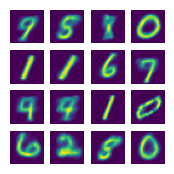

In [95]:
import matplotlib.pyplot as plt
plot_images = iter(output.reshape(16, 28, 28, 1))
fig, ax = plt.subplots(4, 4, figsize=(2, 2))

for x in range(4):
    for y in range(4):
        ax[x, y].imshow(next(plot_images))
        ax[x, y].axis('off')